# Previous Work

The previous net saved in _'01-07-17_convnet.h5'_ , gets a 97% accuracy rate on the test dataset (!) of GTSRB. However, when it must predict on images that don't belong to the GTSRB dataset, it sees traffic signs where there are none, and with very high (~100%) confidence. This is a problem because during a race, the car won't see any traffic signs most of the time.

The approach to fix this, is to add a _background_ class, also called _Zero_ class, as the 43th class to the dataset.

In [57]:
#Load Picture data functions + Load Numpy and Plot library
from utilities.gtsrb_loader.load_data import load_data
from utilities.gtsrb_loader.get_folderpath import get_folderpath
import matplotlib.pyplot as plt
import numpy as np

In [58]:
# Load Trainingsdata (could take 1 or 2 minutes to load data) / X --> images, y --> labels
path = get_folderpath(subset='train', original_images=True)
X_train, y_train = load_data(path)

GTSRB test dataset is in place, you're fine.
/data_on_server/Images/GTSRB/Final_Training/Images


In [59]:
#Load zero class (Pictures with no traffic signs on them)
path_zero = "C:\\Users\\tomas\\Desktop\\GTSRB\\Zero_Class\\ 00043"
X_train_zero, y_train_zero = load_data(path_zero)
print (X_train_zero) #Frage: X_train_zero ist leer?

[]


In [60]:
#Resizing images to 64 x 64
from skimage.transform import resize
X_train_zero = np.array([resize(pic, (64, 64), mode='edge') for pic in X_train_zero])

# Training Set Selection

For this second net, we want to distinguish between _background_ and _traffic sign_ reliably. Thats why I dont balance number of training images per class yet. Any traffic sign does the job. Since our zero class is only in gray color, we will transfor the GTSRB data to grayscale

# Black and White Zero class

In [61]:
#Generate Black and white pictures (First just for class 29 to test)
from skimage import color
x = color.rgb2gray(X_train[0])
print (y_train[0])
print ("Matrix x: (Anzahl Zeilen, Anzahl Spalten)", x.shape)

29
Matrix x: (Anzahl Zeilen, Anzahl Spalten) (36, 27)


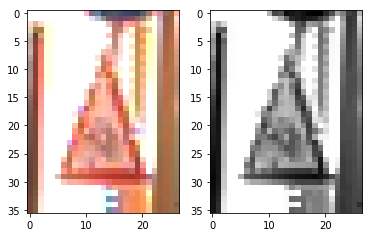

In [62]:
#Show generated grey picture X_train[0]
plt.subplot(1, 2, 1)
plt.imshow(X_train[0])
plt.subplot(1, 2, 2)
plt.imshow(x, cmap='gray')
plt.show()

In [63]:
#Generate Black and white pictures for all classes
X_train_gray = np.array([color.rgb2gray(pic) for pic in X_train])

In [64]:
print (X_train_zero.shape, X_train_gray.shape) #Q: What is the purpose of this line?

(0,) (39209,)


In [65]:
#Pictures get edited in Preprocessing to generate a bigger amount of data

from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(  #Adjust datagenerator
    featurewise_center=True, #Set input mean to 0 over the dataset, feature-wise 
    #Q: What does this line mean?
    featurewise_std_normalization=True, #Divide inputs by std of the dataset, feature-wise. 
    #Q: What does this line mean?
    rotation_range=20, #Pictures get rotated (max. 20°)
    width_shift_range=0.2, #Pictures get shifted horizontally (max. by the factor 0.2)
    height_shift_range=0.2, #Pictures get shifted vertically (max. by the factor 0.2)
    horizontal_flip=True) #Pictures get mirrored horizontally 
    #Q: Is this executed with all signs?

In [66]:
X_train_zero = X_train_zero.reshape(len(X_train_zero), 64, 64, 1) # grayscale wrapper for the datagen object 
X_train_zero.shape

(0, 64, 64, 1)

In [67]:
datagen.fit(X_train_zero) #Compute the internal data stats related to the 
#data-dependent transformations, based on an array of sample data.
#Only required if featurewise_center or featurewise_std_normalization

/usr/local/lib/python3.5/dist-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:73: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:125: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


In [68]:
X_train_gray.max(), X_train_gray.min() #Frage: Was macht diese Funktion

ValueError: operands could not be broadcast together with shapes (36,27) (34,31) 

# Color zero class
since we have a colorfull zeroclass we do not need to transform the pictures to grey


In [69]:
#Load colorful signs
#path = get_folderpath(subset='train', original_images=False)
path="/data_on_server/Images/GTSRB_64x64/Final_Training"
X_train, y_train = load_data(path)


In [70]:
#Load colorful zero classes
#path_zero = "Y:\\Zero_Class_color\\00043"
path_zero = "//data_on_server//Images//Zero_Class_color"
X_train_zero, y_train_zero = load_data(path_zero)

In [71]:
#The whole dataset consists of the zeroclasses as well as the normal signs
X_trainC=X_train+X_train_zero
Y_trainC=y_train+y_train_zero

In [72]:
#List the trainingimages in a numpy array
sign=np.array(Y_trainC)
unique_classes = len(np.unique(sign))
y_trainN = np.eye(unique_classes)[np.array(sign, dtype=int)]
X_trainN = np.array(X_trainC, dtype=np.float32) / 255

In [73]:
#Load Testdata:
path="/data_on_server/Images/GTSRB_64x64/Final_Test"
X_test, Y_test = load_data(path)

In [74]:
#List the testimages in a numpy array
sign_test=np.array(Y_test)
unique_classes_test = len(np.unique(sign_test))+1
Y_testN = np.eye(unique_classes_test)[np.array(sign_test, dtype=int)]
X_testN = np.array(X_test, dtype=np.float32) / 255

In [75]:
#Identify all Trainingimages which have not the specified format
for n in X_trainN:
    if(n.shape != (64,64,3)):
        print(n.shape)

In [76]:
#Number of training images
print (np.array(y_trainN).shape)
print (X_trainN.shape)

(52437, 44)
(52437, 64, 64, 3)


In [77]:
#grayscale wrapper for the datagen object #Q: What should be done here?
X_train = X_trainN.reshape(len(X_train), 64, 64, 3)
X_train.shape

ValueError: cannot reshape array of size 644345856 into shape (48778,64,64,3)

# CHECKPOINT WIP

In [ ]:
# normalize X_train
X_train = np.array(X_train, dtype=np.float32) / 255
# X_train_zero

In [ ]:
# one-hot encode the labels
boundBox=np.array(y_train)[:,0:4]
sign=np.array(y_train)[:,4]
unique_classes = len(np.unique(sign))
y_trainN = np.eye(unique_classes)[np.array(sign, dtype=int)]
y_trainF=np.concatenate([y_trainN,boundBox], axis=1)

In [ ]:
y_trainF



## Define Network:
From Keras docs, VGG-like Convnet.

First Block (Convolutional Block)

In [78]:
#Import Keras Model libraries
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

In [79]:
#Generate Sequential model
model = Sequential()

In [80]:
#Add 2D convolution layer
model.add(Conv2D(input_shape=(64, 64, 3), # Specifying the input shape
                 filters=32, #Number of filters
                 kernel_size=(3, 3), #Filtersize (3x3 filter)
                 activation='relu')) #Activation function is Rectifier

In [81]:
#Add 2D convolution layer
model.add(Conv2D(filters=32,
                 kernel_size=(3, 3),
                 activation='relu'))

In [82]:
#Add MaxPooling layer
model.add(MaxPooling2D(pool_size=(2, 2))) #poolsize 2x2

In [83]:
#Applies Dropout to the input. Dropout consists in randomly setting a fraction rate (here 0.25) of input units to 0
# at each update during training time, which helps prevent overfitting.
model.add(Dropout(0.25))

Second Block (Convolutional Block)

In [84]:
#Add 2D convolution layer
model.add(Conv2D(filters=64, #Number of filters
                 kernel_size=(3, 3), #Filtersize (3x3 filter)
                 activation='relu')) #Activation function is Rectifier

In [85]:
#Add 2D convolution layer
model.add(Conv2D(filters=64, #Number of filters
                 kernel_size=(3, 3), #Filtersize (3x3 filter)
                 activation='relu')) #Activation function is Rectifier

In [86]:
#Add MaxPooling layer
model.add(MaxPooling2D(pool_size=(2, 2))) #poolsize 2x2

In [87]:
#Applies Dropout to the input. Dropout consists in randomly setting a fraction rate (here 0.25) of input units to 0
# at each update during training time, which helps prevent overfitting.
model.add(Dropout(0.25))

Third Block (Fully Connected Layers)

In [88]:
#Flatten the input --> From 2D-Array to 1D-Array
model.add(Flatten())

In [89]:
#Add fullyconnected layers
model.add(Dense(200, activation='relu')) #Add layer with 200 neurons with rectifier activation function
model.add(Dropout(0.5)) #Applies Dropout to the input --> fraction rate is here 0.5
model.add(Dense(44, activation='softmax')) #Add layer with 44 neurons with softmax activation function

Define critical parameters for network (SGD-optimizer, tensorboard)

In [ ]:
#Stochastic gradient descent optimizer.
#Includes support for momentum, learning rate decay, and Nesterov momentum.
from keras.optimizers import SGD
sgd = SGD(lr=0.01, #Learningrate = 0.01, 
          decay=1e-6, #decay (Factor to decrease the learningrate over time),
          momentum=0.9, #momentum (former gradient descents are considered to increase the speed of convergence)= 0.9
          nesterov=True) #Nesterov momentum is used (method to reduce the probability to not find minima because of high momentum)

In [99]:
model.compile(loss='categorical_crossentropy', #As lossfunction y_true and y_pred are compared in every category
              optimizer=sgd, #Stochastic gradient descent optimizers are used
              metrics=['accuracy']) #List of metrics to be evaluated by the model during training and testing --> Here: accuracy.

In [100]:
#Tensorboard
from keras.callbacks import TensorBoard

tensorboard = TensorBoard(log_dir='./logs', #Path of directory where to save the log files to be parsed by TensorBoard.
                          histogram_freq=0, #frequency (in epochs) at which to compute activation and weight histograms
                                            #If set to 0, histograms won't be computed.
                          write_graph=True, #Visualize the graph in TensorBoard.
                          write_images=False) #Write model weights to visualize as image in TensorBoard.

In [ ]:
#Other Callbacks: #Q: Where are they used?
from keras.callbacks import Callback
class TestCallback(Callback):
    def __init__(self, test_data):
        self.test_data = test_data

    def on_epoch_end(self, epoch, logs={}):
        x, y = self.test_data
        loss, acc = self.model.evaluate(x, y, verbose=0)
        print('\nTesting loss: {}, acc: {}\n'.format(loss, acc))

#Q: What is this/ Is this training function used?
model.fit(X_trainN, y_trainN, batch_size=32, epochs=50, validation_data=(X_testN, Y_testN), shuffle=True, callbacks=[TestCallback((X_testN, Y_testN))])

## Train Model

In [ ]:
#Train model with tensorborad
model.fit(X_trainN, y_trainN, batch_size=32, epochs=50, validation_data=(X_testN, Y_testN), shuffle=True, callbacks=[tensorboard])

Train on 52437 samples, validate on 12630 samples
Epoch 1/50
52437/52437 [==============================] - 304s - loss: 1.1202 - acc: 0.6715 - val_loss: 0.3015 - val_acc: 0.9137
Epoch 2/50
52437/52437 [==============================] - 304s - loss: 0.2011 - acc: 0.9393 - val_loss: 0.2061 - val_acc: 0.9428
Epoch 3/50
52437/52437 [==============================] - 304s - loss: 0.1113 - acc: 0.9662 - val_loss: 0.1372 - val_acc: 0.9638
Epoch 4/50
52437/52437 [==============================] - 304s - loss: 0.0793 - acc: 0.9760 - val_loss: 0.1240 - val_acc: 0.9689
Epoch 5/50
52437/52437 [==============================] - 303s - loss: 0.0584 - acc: 0.9820 - val_loss: 0.1496 - val_acc: 0.9644
Epoch 6/50
52437/52437 [==============================] - 304s - loss: 0.0503 - acc: 0.9845 - val_loss: 0.1107 - val_acc: 0.9713
Epoch 7/50
22752/52437 [============>.................] - ETA: 161s - loss: 0.0426 - acc: 0.9871

In [ ]:
#Define model with TestCallback
#Q: Will this be done?

In [ ]:
#Training without tensorboard
model.fit(X_trainN, y_trainN, batch_size=32, verbose=2 ,epochs=20)
#Q: What is the benefit of training with and without tensorboard

In [ ]:
#Save model
model.save('16-10-17_convnet_Zero_color_E50.h5')